Wind-Aware Dubins Trajectory Planner for Small UAS
==============


A dubins path represents the shortest path between two given points on a 2D plane. Originally proposed by Lester Eli Dubins in 1957. A dubins path is purely a geometric construction consisting of three segments: a turn segments, a straight segment/turn segment and a turn segment. The directionality of the turn (left/right) results in eight possible solutions of type $RSR,RSL,LSR,LSL,RL_1R,RL_2R,LR_1L,LR_2L$. Here $L$ denotes a left turn, $R$ denotes a right turn,$S$ denotes a straight segment. The $1$ subscript denots a turn involving a heading change less than $\pi$, and the $2$ subscript denotes a heading change greater than $\pi$. However, not all these solutions will be availabe for a given set of initial and final conditions. A good reference for implementing a dubins path can be found in [1,Beard, Mclain].

Consider a small UAV, that is capable of making a turn with radius of $turnR$. Let SP denote its initial position, hStart denote it intial orientation, EP denote its final position and hEnd denote its final heading. 

In [1]:
from Utils import *

# turn radius in meters
turnR = 2 

# Starting orientation in degrees
hStart = 50

# Final orientation in degrees
hEnd = 90 

# Starting position (North-East meters)
SP = np.array([[0.0],[0.0]])

# Ending position (North-East meters)
EP = np.array([[13.0],[10.0]])

Given the above initial conditions, the dubins path is described by a set of parameters which define the center of the intial and final turn, the transition point from a turn to the straight segment and vice versa. An implementation of the dubins path algorithm for the 2D case can be found in the `DubinsPath2D.py` file. The cell below indicates the various paths for the above initial condition. Typically case 1 to 4 are available if the distance between the intial and final turn centers are $\geq3R$. 

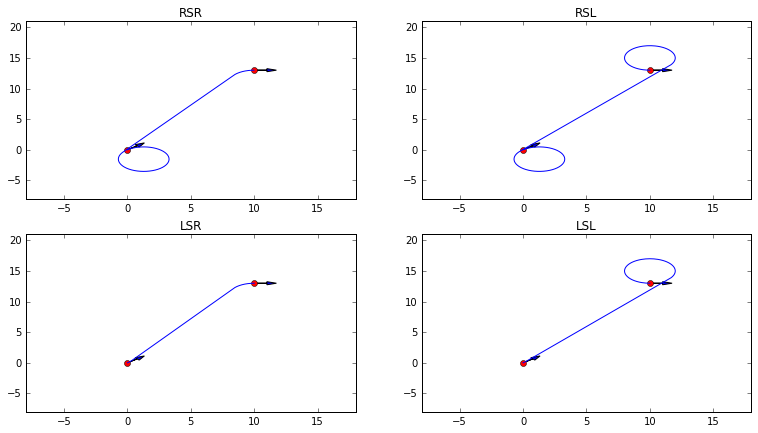

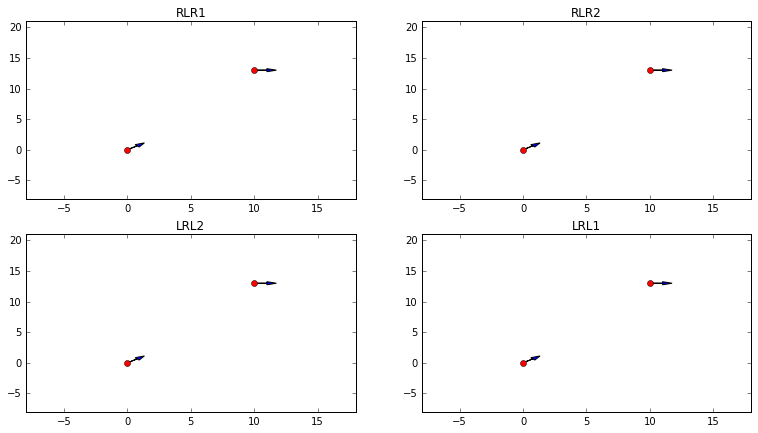

In [2]:
from DubinsPath2D import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [13, 7]

# Compute dubins parameters for each case and plot the dubins path
for i in range(1,9):
    (case,status,paramsCSC,paramsCCC) = FindDubinsParameters2D(SP,EP,hStart,hEnd,turnR,i)
    
    PlotPath2D(SP,EP,hStart,hEnd,turnR,case,status,paramsCSC,paramsCCC)

Dubins path in 3D
--------

Generating the dubins path in 3D requires consideraion of the glide ratio or descent rate of the aircraft (both in the straight segments and turn segments). Let $\Delta_H$ represent the altitude difference between the initial and final conditions. Without loss of generatlity, given a certain glide ratio for the turn ($\delta_t$) and straight segments ($\delta_s$), the following steps are used to compute the 3D dubins path:

- Compute the 2D dubins path for the given initial and final positions (project the 3D positions to the X-Y plane).
- Calculate the total altitude drop ($\delta_H$) by summing the altitude drop for each segment using the appropriate glide ratio.
- If $\Delta_H$ - $\delta_H$ = 0, then return the computed 2D path.
- Else if $\Delta_H$ - $\delta_H$ > 0, reduce the glide path angles of either the straight or turn segments to get to target altitude.
- Else if $\Delta_H$ - $\delta_H$ < 0, introduce additional spiral turn segments to lose excess altitude. i.e.: $numSpiralTurns = floor(\frac{\Delta_H-\delta_H}{2\pi r\delta_t})$
- What ever altitude remains ($\delta_h$) after the $numSpiralTurns$ segment (i.e. $\big(\frac{\Delta_H-\delta_H}{2\pi r\delta_t} - numSprialTurns\big)2\pi r\delta_t$, can be lost by introducing an extended final segment.
- However, after completing the $numSprialTurns$ the aircraft would be ideally located above the runway threshold. Therefore, we push the (x,y) coordinates of the original end condition by $\frac{\delta_h}{2\delta_s}$, $180 \deg$ away from the runway heading.
- Note that pushing the original end condition away from the runway as described above also changes the dubins parameters and requires that the entire dubins plan be recomputed with the new end condition.
- Finally, the dubins path would arrive at the runway with an excess altitude of $\frac{\delta_h}{2}$. Consequently, this altitude drop is accomdated by introducing S-turn segments in the straight path of the dubins path.

The cell below generates the 3D path as described above


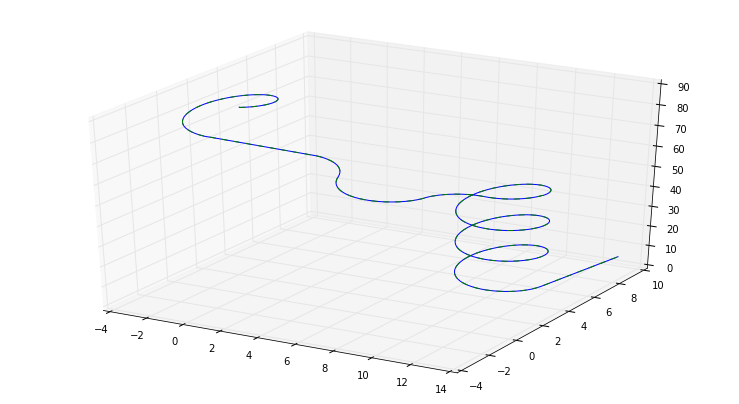

In [3]:
from DubinsPath3D import *

# Starting altitude (in meters)
startAlt = 90.0

# Straight segment glide ratio
glide_s = 1.0

# Turn segment glide ratio
glide_t = 1.2

case = 1

(case,status,paramsCSC,paramsCCC,paramsALT) = FindDubinsParameters3D(SP,EP,hStart,hEnd,turnR,case,startAlt,\
                                                                     glide_s,glide_t)

PlotPath3D(SP,EP,hStart,hEnd,turnR,startAlt,case,status,paramsCSC,paramsCCC,paramsALT)

Dubins paths with winds
----

In the absence of winds, a vehicle following a dubins path in the air follows the exact same path over the surface of the earth. However, the presence of winds causes the path followed over the ground to be different than the dubins path in the air.

The ground path is computed by shifting each point on the air path by $[V_w*\cos(\psi_w),V_w*\sin(\psi_w)]\Delta_T$ where $V_w$ represents the wind speed, $\psi_w$ represents the wind direction. $\Delta_T$ time represents the time elapsed at the given point on the air path.

The cell below, illustrates the ground path in the presence of winds:

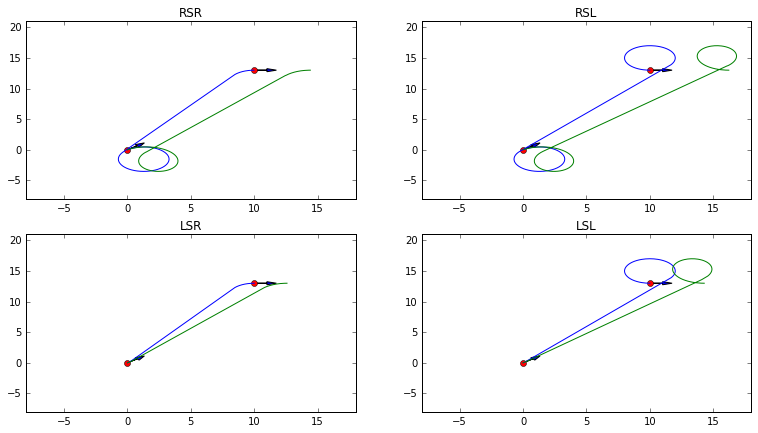

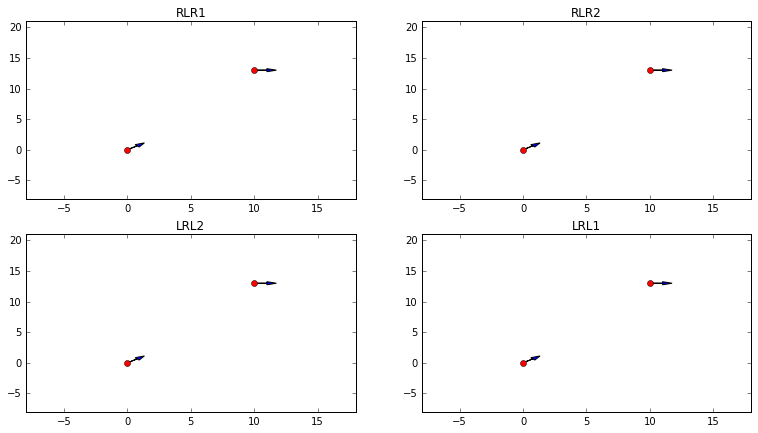

In [4]:
#Airspeed
airspeed = 2.0
windspeed = 0.3
winddirection = 90

# Compute dubins parameters for each case and plot the dubins path
for i in range(1,9):
    (case,status,paramsCSC,paramsCCC) = FindDubinsParameters2D(SP,EP,hStart,hEnd,turnR,i)
    
    PlotPath2D(SP,EP,hStart,hEnd,turnR,case,status,paramsCSC,paramsCCC,showGroundPath=True,\
               airspeed=airspeed,windspeed=windspeed,winddirection=winddirection)

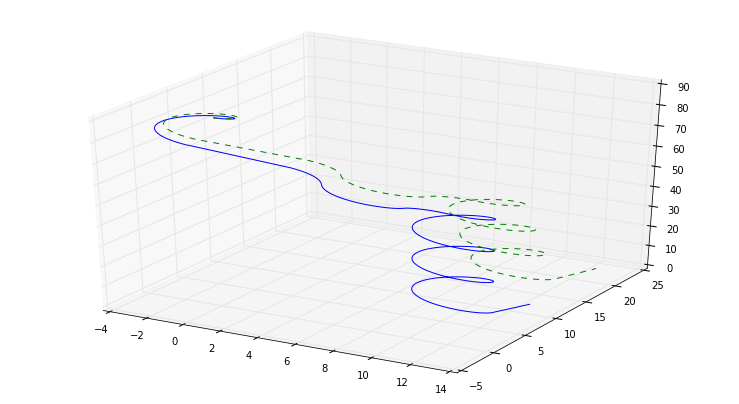

In [5]:
case = 1

(case,status,paramsCSC,paramsCCC,paramsALT) = FindDubinsParameters3D(SP,EP,hStart,hEnd,turnR,case,startAlt,\
                                                                     glide_s,glide_t)

PlotPath3D(SP,EP,hStart,hEnd,turnR,startAlt,case,status,paramsCSC,paramsCCC,paramsALT,\
           showGroundPath=True,airspeed=airspeed,windspeed=0.3,winddirection=90)

## Computing a path to target given wind speed and direction

To account for wind, first compute the no-wind path. Then compute the deviation induced on this path due to the given wind speed and wind direction. Now compute the difference between this new end condition due to the wind and the original end condition. Consider a virtual end condition in the opposite direction of the shift. A little iteration is required to get to the actual end condition as shown in this algorithm

In [6]:
endPosVirtual = EP
error = 1e3
success = False
case = 1
turnRate = airspeed/turnR

(case,status,paramsCSC,paramsCCC) = FindDubinsParameters2D(SP,EP,hStart,hEnd,turnR,case)

if status and not success:
    if(case <= 4):
        params = paramsCSC
    else:
        params = paramsCCC

    (X,Y,lengthA) = GenerateDubinsAirPath2D(SP,hStart,EP,hEnd,turnR,case,params)
    (Xg,Yg,lengthG) = GenerateDubinsGroundPath2D(airspeed,windspeed,winddirection,SP,hStart,EP,\
                                                 hEnd,turnR,case,params)

    timeTaken = lengthA[0]/turnRate + lengthA[1]/airspeed
    
    shift =  np.array([[-windspeed*cos(winddirection*pi/180)*timeTaken],\
                       [-windspeed*sin(winddirection*pi/180)*timeTaken]])

    shiftDist = dist(np.zeros((2,1)),shift)

    while shiftDist > 1e-1:

        # Shifted destination
        endPosVirtual = endPosVirtual + shift
        (case,status,paramsCSC,paramsCCC) = FindDubinsParameters2D(SP,endPosVirtual,hStart,hEnd,turnR,case)

        if status is True:
            if(case <= 4):
                params = paramsCSC
            else:
                params = paramsCCC

            (Xg,Yg,lengthG) = GenerateDubinsGroundPath2D(airspeed,windspeed,winddirection,SP,\
                                                         hStart,endPosVirtual,hEnd,turnR,case,params)
            shift = np.array([[EP[0,0] - Xg[-1]],[EP[1,0] - Yg[-1]]])
            shiftDist = dist(np.zeros((2,1)),shift)
        else:
            break

    if shiftDist < 1e-1:
        success = True
        print endPosVirtual
    else:
        success = False

[[ 13.        ]
 [  5.87961051]]


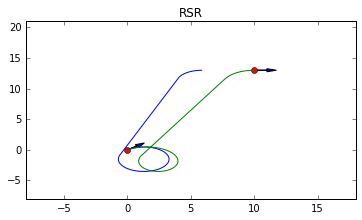

In [7]:
PlotPath2D(SP,EP,hStart,hEnd,turnR,case,status,paramsCSC,paramsCCC,showGroundPath=True,\
               airspeed=airspeed,windspeed=windspeed,winddirection=winddirection)